## Packages

In [1]:
# Initial packages:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

## Generate Training Data:

Generate the training data for the emissivity-temperature relation. The ideal mathematical form of the emissivity-temperature relation is:

$$\varepsilon(T)=\left[1+5 \sin \left(\dfrac{3 \pi}{200} T\right)+\exp (0.02 T)\right] \times 10^{-4}$$

the training data is generated by adding a zero-mean Gaussian noise to the analytical relation. The Gaussian noise follows the normal distribution:

$$\epsilon \sim N(\mu, \sigma^2)$$

where $\mu=0$, and $\sigma=0.3$.

The data used for training MLP model is sampled within range:  $T \in[0,60]$,


In [2]:
n_data = 80
X_theo=np.linspace(0,60,n_data)
Y_theo = (1 + 5*np.sin(3*np.pi/200*X_theo) + np.exp(0.02*X_theo) )

np.random.seed(5)
X_total=np.linspace(0,60,n_data)
# X_total = np.random.uniform(0,60,n_data)
Y_exp = (1 + 5*np.sin(3*np.pi/200*X_total) + np.exp(0.02*X_total) + np.random.normal(0, 0.3, n_data) )

<IPython.core.display.Javascript object>


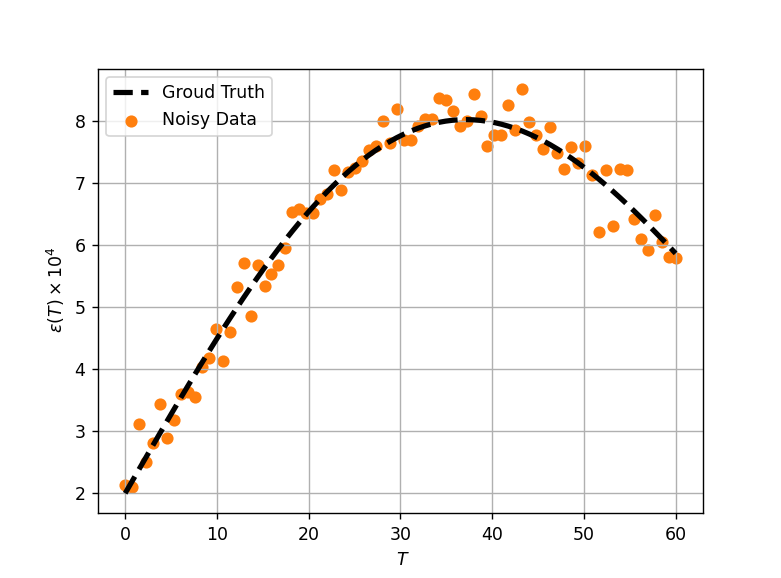

In [4]:
# plot the training data
fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_data_01 = ax.scatter(X_total,Y_exp,color='C1')

ax.set_ylabel(r" ${\varepsilon(T)} \times 10^4$ ")
ax.set_xlabel(r" ${T}$ ")
ax.legend(handles=[l_theo[0],l_data_01],
           labels=['Groud Truth','Noisy Data'],loc='best')
ax.grid()

## Create Pandas data frame

In [5]:
column_names = ['Temperature','Radioactive rate']
dataset = pd.DataFrame(data=np.transpose([X_total,Y_exp]), columns=column_names )
dataset.tail()

,Temperature,Radioactive rate
75,56.962025,5.913000
76,57.721519,6.479798
77,58.481013,6.041358
78,59.240506,5.804810
79,60.000000,5.792176


In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_labels = train_dataset.pop('Radioactive rate')
test_labels = test_dataset.pop('Radioactive rate')

## Training the NN in Tensorflow

In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
print(keras.__version__)
tf.keras.backend.set_floatx('float64')

2.3.0-tf


In [8]:
# NN model function
def build_model(l1_weight=3e-05, l2_weight=8e-04):
  model = keras.Sequential([
    layers.Dense(32, activation='tanh', input_shape=[len(train_dataset.keys())], 
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_weight, l2=l2_weight)),
    layers.Dense(32, activation='tanh',
                 kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_weight, l2=l2_weight)),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 1000 == 0: print('')
    if epoch % 10 == 0: print('.', end='')

In [9]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(train_dataset, train_labels, epochs=15000,
                    verbose=0, 
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Model performance

In [12]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig, axs = plt.subplots(1,2,figsize=(7,3.3))
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Mean Abs Error [MPG]')
  axs[0].plot(hist['epoch'], hist['mae'],
           label='Train Error')
  axs[0].legend()

  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Mean Square Error [$MPG^2$]')
  axs[1].plot(hist['epoch'], hist['mse'],
           label='Train Error')

  axs[1].legend()
  plt.show()


plot_history(history)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


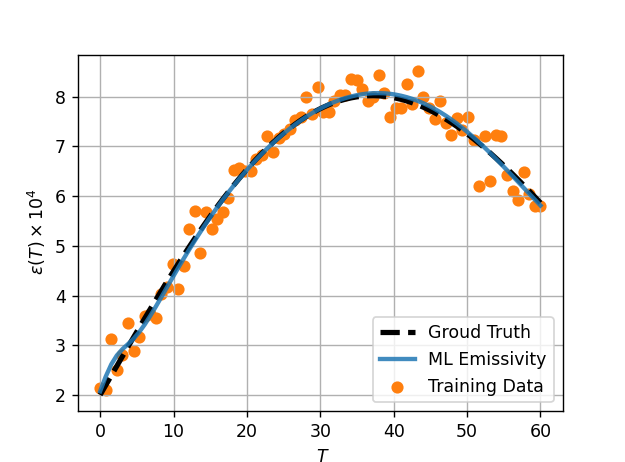

In [19]:
test_predictions = model.predict(X_theo).flatten()

fig, ax=plt.subplots(figsize = (5,3.7))
l_theo = ax.plot(X_theo,Y_theo,lw=3, color='k',linestyle='--')
l_ml = ax.plot(X_theo,test_predictions,lw=2.5, color='C0', alpha=0.85)
l_data = ax.scatter(X_total,Y_exp,color='C1')

ax.set_ylabel(r" $\varepsilon(T) \times 10^4$ ")
ax.set_xlabel(r" $T$ ")
ax.legend(handles=[l_theo[0],l_ml[0],l_data],
          labels=['Groud Truth','ML Emissivity','Training Data'],loc='best')
ax.grid()


## Save Trained Model

### SavedModel Format:

In [20]:
model.save('Heat_Model_DP_OPT', save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Heat_Model_DP_OPT/assets


### PB Format:

In [21]:
from tensorflow import keras
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name="Input"))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 50)
print("Frozen model layers: ")
for layer in layers:
    print(layer)

print("-" * 50)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="./heat_model_dp_pb_opt",
                  name="simple_frozen_graph_opt.pb",
                  as_text=False)

--------------------------------------------------
Frozen model layers: 
Input
sequential/dense/MatMul/ReadVariableOp/resource
sequential/dense/MatMul/ReadVariableOp
sequential/dense/MatMul
sequential/dense/BiasAdd/ReadVariableOp/resource
sequential/dense/BiasAdd/ReadVariableOp
sequential/dense/BiasAdd
sequential/dense/Tanh
sequential/dense_1/MatMul/ReadVariableOp/resource
sequential/dense_1/MatMul/ReadVariableOp
sequential/dense_1/MatMul
sequential/dense_1/BiasAdd/ReadVariableOp/resource
sequential/dense_1/BiasAdd/ReadVariableOp
sequential/dense_1/BiasAdd
sequential/dense_1/Tanh
sequential/dense_2/MatMul/ReadVariableOp/resource
sequential/dense_2/MatMul/ReadVariableOp
sequential/dense_2/MatMul
sequential/dense_2/BiasAdd/ReadVariableOp/resource
sequential/dense_2/BiasAdd/ReadVariableOp
sequential/dense_2/BiasAdd
Identity
--------------------------------------------------
Frozen model inputs: 
[<tf.Tensor 'Input:0' shape=(None, 1) dtype=float64>]
Frozen model outputs: 
[<tf.Tensor 'Iden

'./heat_model_dp_pb_opt/simple_frozen_graph_opt.pb'